<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/communicatie/marketing/aanbesteding/artwork-textiel/kuleuven-logo.png" width = "300px" heigh = "auto" align="left">
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: r0902260, r0977251, r1003576, r1005663, r0375658.

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 1* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/d11be6a431b84198bc85f54ae7e2563f) prior to the deadline on **Tuesday 24 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 2* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

In [ ]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [ ]:
#take first 20 columns the values of 0 and 1 of the dataframe as labels
labels_df = train_df.iloc[:, :20]
labels_train = labels_df.values
print(labels_train[0])

In [ ]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

In [ ]:
# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

Lets plot the number of occurences of each class to see if our data is balanced:

In [ ]:
#count the number of occurences of each class in the label set
class_distribution = train_df[labels].sum(axis=0)

fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(labels, class_distribution)
ax.set_title('Counts')
ax.xaxis.tick_top()
plt.show()

When looking at the barchart its becomes clear that the classes are not balanced. There are 4 more instances of the person class in our dataset. This makes sense because a person is likely to be close to the other classes like for example bicycle. Now we know that our training is not balanced this is something we need te take care of in later steps.

## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [6]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

The images are resized to and converted to numpy array to be able to work with our network:

In [ ]:
# Define a function to resize images
def resize_images(img_series, size=(128, 128)):
    return img_series.apply(lambda img: cv2.resize(img, size))

# Resize and convert the images to a numpy array
train_images = np.stack(resize_images(train_df["img"]).values)
test_images = np.stack(resize_images(test_df["img"]).values)
#define train labels and test labels
train_labels = labels_train
#test_labels = 
X_test = test_images

The train data is split in validation and training set. Where the validation is 10% of the total data.

In [ ]:
from sklearn.model_selection import train_test_split
# Divide full training set into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=0)

## 2.1 Normalization and standardization

Normalization ensures that the pixel values of images fall within a consistent range. Neural networks learn their weights by adjusting them based on gradient error vectors during training. If input features have different scales, the learning rate may cause corrections in each dimension that differ from one another. Normalizing the images helps prevent overcompensation or slow convergence.

Standardization transforms pixel values to have a zero mean and unit variance. Standardization helps when features have different units or scales. It ensures that all features contribute equally during training.

In [ ]:
import random

#shuffle
def preprocess_sets(X_train, X_val, X_test, standardize=True):

  print(y_train[0])
  #show image y_train[0]
  print(y_train[1])

  #normalization
  X_train = np.array(X_train, dtype=np.float32) / 255.0
  X_test = np.array(X_test, dtype=np.float32) / 255.0
  X_val = np.array(X_val, dtype=np.float32) / 255.0

  #standardization
  if (standardize):
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_test -= X_train_mean
    X_val -= X_train_mean
  
  plt.imshow(X_train[0])
  plt.show()
  plt.imshow(X_train[1])
  plt.show()



  return X_train, X_val,X_test

In [ ]:
X_train, X_val, X_test = preprocess_sets(X_train, X_val, X_test)

## 2.2 Metrics and loss function

### 2.1.1 Weighting classes

As discusses before our dataset is imbalanced. Models trained on imbalanced data tend to be biased toward the majority class. They may perform poorly on the minority class. The model may have high accuracy but low recall (true positive rate) for the minority class. It might miss important instances. To address class imbalance, we can use a weighted loss function during training.

In [ ]:
from sklearn.utils import class_weight


def calculating_class_weights(y_true):
    weights = np.empty([20, 2]) # 20 classes
    for i in range(20):
    
        weights[i] = class_weight.compute_class_weight('balanced', classes = np.array([0,1]), y = y_true[:, i])
      
    return weights

class_weights = calculating_class_weights(y_train)
class_weights

### 2.1.2 Weighted binary cross entropy

In [ ]:
def get_weighted_loss(weights):
      def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
      return weighted_loss

### 2.1.3 F1-Score

Because we have an unbalanced data set and an multilabel classification problem its not a good idea to use accuracy. Imagine we have a class that only occurs one time in the dataset of 100. If we optimise our classifier it can just optimise to never classify that class to achieve a accuracy of 99%. This is a good accuracy but not classification that we want. We need to use other metrics like f1-score or hamming loss.

In [ ]:
def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall + K.epsilon())
  return f1_val

## 2.3 Classification from skratch VGG CNN

VGG (Visual Geometry Group) is a convolutional neural network architecture that was proposed by researchers from the University of Oxford in 2014. It gained popularity and recognition for its simplicity and effectiveness in image classification tasks.

The VGG neural network architecture, as described in the original paper aims to address the challenge of image classification using deep convolutional neural networks. The primary focus of the VGG architecture is on increasing the depth of the network while using simple and uniform convolutional layers.

In [ ]:
def build_tiny_vgg(cam=False):
  model = Sequential()
  input_shape = (128,128,3)
  channel_dim = -1
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    channel_dim = 1
  model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(Conv2D(128, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=channel_dim))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(20)) 
  model.add(Activation('sigmoid'))

  if cam == True:
    model_ = Sequential()
    for layer in model.layers[0:19]:
      model_.add(layer)
    model_.add(GlobalAveragePooling2D())
    model_.add(Dense(20)) 
    model_.add(Activation('sigmoid'))
  
    return model_
  
  return model
  
print("Amount of layers: ", len(build_tiny_vgg().layers))

In [ ]:
def train_classifier(model, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size, filepath):

  # callbacks
  save_best = ModelCheckpoint(filepath, monitor='val_get_f1', verbose=0, 
                              save_best_only=True, mode='max', period=1)
    
  model.compile(loss=get_weighted_loss(class_weights),
                optimizer=optimizer,
                metrics=[get_f1, "accuracy"])

  # data augmentation
  datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.2
                               ,height_shift_range=0.2, shear_range=0.2,zoom_range=0.2
                               ,fill_mode="nearest", horizontal_flip=True)

  datagen.fit(X_train)

  # training
  history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          validation_data=(X_val, y_val), steps_per_epoch = len(X_train) // batch_size,
                          epochs=epochs, verbose=1, workers=4, callbacks=[save_best], shuffle=True)
  return model, history

In [ ]:
from keras.models import load_model

training = False
model = None
model_cam = None
history = None
history_cam = None
epochs = [200, 100]

# Convert labels to float type
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')


if training:
  model, history = train_classifier(build_tiny_vgg(),tf.keras.optimizers.Adam(learning_rate=0.001), X_train,  y_train,
                                    X_val, y_val, epochs[0], 32, 'tinyvgg.h5' )
  model_cam, history_cam = train_classifier(build_tiny_vgg(cam=True),'adam', X_train,  y_train,
                                    X_val, y_val, epochs[1], 32, 'tinyvgg_gap.h5' )
else:

  model = load_model('tinyvgg.h5', custom_objects={
        'get_f1': get_f1,
        'weighted_loss': get_weighted_loss(class_weights)
  })
  model_cam = load_model('tinyvgg_gap.h5', custom_objects={
        'get_f1': get_f1,
        'weighted_loss': get_weighted_loss(class_weights)
  })

In [ ]:
if training:
  epochs = 200
  plt.style.use("ggplot")
  plt.figure()
  plt.ylim(top=1.5)
  plt.plot(np.arange(0, epochs), history.history["loss"], label="training loss")
  plt.plot(np.arange(0, epochs), history.history["val_loss"], label="validation loss")
  plt.title("Training result")
  plt.xlabel("Epoch")
  plt.legend(loc="upper right")
  plt.show()

In [ ]:
if training:
  epochs = 200
  plt.style.use("ggplot")
  plt.figure()
  plt.ylim(top=1)
  plt.plot(np.arange(0, epochs), history.history["get_f1"], label="training F1")
  plt.plot(np.arange(0, epochs), history.history["val_get_f1"], label="validation F1")
  plt.title("Training result")
  plt.xlabel("Epoch")
  plt.legend(loc="upper right")
  plt.show()

## 2.4 Classification from skratch Binary Classifiers

In [ ]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(128,128,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  #Depends on number of classes
  
    return model

In [ ]:
import os
import gc
from keras.models import load_model
from keras import backend as K

y_pred_all = np.zeros((X_test.shape[0], num_classes))

for i in range(num_classes):
    model_path = f'model_class_{i}.h5'
    if os.path.exists(model_path):
        model = load_model(model_path, custom_objects={
        'get_f1': get_f1,
        'weighted_loss': get_weighted_loss(class_weights)
  })
    else:
       
        model, history = train_classifier_binary(build_model(),tf.keras.optimizers.Adam(learning_rate=0.001), X_train, y_train[:,i],X_val, y_val[:,i], 30, 32, model_path)
    
    y_pred = model.predict(X_val)
    y_pred[y_pred>=threshold] = 1
    y_pred[y_pred<threshold] = 0

    #count the number of correct predictions and the number of wrong predictions
    correct = np.sum(y_pred == y_val[:,i])
    wrong = np.sum(y_pred != y_val[:,i])

    
    print(f'Class {i}: correct predictions: {correct}, wrong predictions: {wrong}')

    #print accuracy and f1
    print(f'Class {i}: Accuracy: {correct/y_val.shape[0]}')
    print(f'Class {i}: F1: {f1_score(y_val[:,i], y_pred)}')

    #determine optimal threshold ov validation
     #f1_scores = []
     #thresholds = np.arange(0, 1.1, 0.1)
     #for threshold in thresholds:
        #y_pred = model.predict(X_val)
        # y_pred[y_pred>=threshold] = 1
        # y_pred[y_pred<threshold] = 0
        # f1_scores.append(f1_score(y_val[:,i], y_pred))
     # #optimal_threshold = thresholds[np.argmax(f1_scores)]
     #print(f'Optimal threshold: {optimal_threshold}')
    optimal_threshold = 0.5



    y_pred = model.predict(X_test)

    
    y_pred[y_pred>=optimal_threshold] = 1
    y_pred[y_pred<optimal_threshold] = 0

    y_pred_all[:, i] = y_pred.flatten()




    # Clear the session to free up memory
    K.clear_session()

    # Delete the model
    del model

    # Call the garbage collector
    gc.collect()

print(y_pred_all)


# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

In [ ]:
class RandomSegmentationModel:
    """
    Random segmentation model: 
        - generates random label maps for the inputs based on the class distributions observed during training
        - every pixel in an input can only have one label
    """
    def fit(self, X, Y):
        """
        Adjusts the class ratio variable to the one observed in Y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        Y: list of arrays - n x (height x width)

        Returns
        -------
        self
        """
        self.distribution = np.mean([[np.sum(Y_ == i) / Y_.size for i in range(len(labels) + 1)] for Y_ in Y], axis=0)
        print("Setting class distribution to:\nbackground: {}\n{}".format(self.distribution[0], "\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution[1:]))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        np.random.seed(0)
        return [np.random.choice(np.arange(len(labels) + 1), size=X_.shape[:2], p=self.distribution) for X_ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
model = RandomSegmentationModel()
model.fit(train_df["img"], train_df["seg"])
test_df.loc[:, "seg"] = model.predict(test_df["img"])
test_df.head(1)

# Summary of Various Tests using Keras package

First, as suggested in the assignment's instructions, we tried to implement a deep learning network using tensorflow and keras packages.

**Pre-processing of Data:** 

A SegmentationDataset class was created to correctly upload all images and their corresponding segmentation masks as mini-batches, after applying a resize operation in order to have a fixed identical size for all inputs in our model. As usual, the files received for training were separated into a training and a validation subsets. Of note, for the segmentation task, in addition to the 20 classes available in the dataset, we thus have an extra one defined for the background (class = 0) giving us a total of 21 classes.

**Models for Image Segmentation:**

In opposite to a more simple image classification problem, image segmentation problems suffer a lot from the loss in resolution occurring in standard convolutional neural networks through the pooling and upsampling layers. Although it doesn't affect the classification task as much since more global features are enough, it does affect the segmentation quite a lot since fine details are important to classify each pixel correctly. Different architectures for CNNs have been developped in such a way to keep both local information from earlier layers and global information from deeper layers. Two of them are the SegNet and the U-Net, and those are the ones we tried first.

The U-Net architecture, originally proposed by Ronneberger et al. (2015)[1] for biomedical image segmentation, is composed of an encoder, a decoder and some skip connections. The idea is that the encoder path captures the context while the skip connections path captures the exact localization. We followed the same network architecture as the one that was described in their paper. The contracting path is similar to a typical CNN architecture, i.e. composed of repeated steps of two convolutional layers followed by ReLU activation plus a max pooling operation. On the other side, each step of the expansive path is composed of: an upsampling and upconvolution operation, followed by a concatenation with the corresponding feature map from the contracting path (through the skip connections) and finally two convolutional layers followed by ReLU activation.

The SegNet architecture, originally proposed by Badrinarayanan et al. (2016)[2] for road scene understanding applications, is also composed of an encoder, a decoder and some additional direct connections between encoder and decoder layers. The idea behind the SegNet is that each decoder step uses the max-pooling indices coming from the corresponding encoder step. The encoder part follows the architecture of the convolutional layers of the VGG16 (excluding thus the fully connected layers). The reusing of the max pooling indices in the decoder part reduces the total number of parameters, making the training of SegNet faster than other architectures.

**Training of Models:**

Our first attempts of training those two models were done using the predefined categorical crossentropy loss function <span style="color:red"> [@TJALLING: did you try other predefined loss function?] </span> as well as a customized Dice loss function. With the two of them (testing on a quite small number of epoch), we got stucked with models that were predicting all pixels as background. 

As we couldn't find a predefined weighted categorical crossentropy in the keras library, we adapted our customized Dice loss function in order to take the class_weights into account. Then, we also tried to give more importance to the mistakes done on foreground classes compared to background class by adding an extra penalty on the loss. We tested different versions of this customized function, changing for example the weight of the penalty, or how the background class was taken into account. It did improve our results compared to the original Dice loss function as the model was able to predict different classes. Visually, we could recognize shapes of different objects in the segmentation mask of the images. However, the actual classes chosen didn't really make sense. Looking at the training loss curves, it looks like the models weren't really learning correctly. 

We also gave new attempts coming back to more a standard loss function that would take weights imbalance into account, and tried to implement the generalized Dice loss function as described in Cardoso et al. (2017)[3], with no success as we were back to background being predicted for all pixels.

At that point, and after hours of testing and training models, we decided to switch to PyTorch package because we have more experiences of it through our master thesis. And we started testing other models with more classic weighted loss function, and optimization of other hyper parameters, see next section.

As documentation, our codes were kept in an appendices section 6 at the end of this notebook.

-----------
REFERENCES: 
* [1] Ronneberger et al., U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015.
* [2] Badrinarayanan et al., SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation, 2016.
* [3] Cardoso et al., Deep Learning in Medical Image Analysis and Multimodal Learning for Clinical Decision Support, 2017.

# Segmentation Models using PyTorch

# Models trained from scratch

In PyTorch, we implemented and trained from scratch the U-Net model, which has already been described in the previous section. On one side, we tried to use the architecture from the original paper [1] as done in our test with Keras. In addition, in parallel, we also developed another customized U-Net model that would use more neurons in each layers in order to make it more complex.

# Loss function:

 The cross entropy loss is well adapted for image segmentation as it evaluates the class predictions for each pixel and then average the loss for all pixels. As we have clear imbalanced classes - background class vs other class, but also among the foreground classes - we have used the weighted version of the cross entropy loss. From the PyTorch library, we were now able to use the predefined cross entropy loss function with weights.

# Metrics:

After doing the first attempts in Keras looking at AUC/Recall/Precision metrics, we realized that Intersection over Union (IoU) was actually a better, if not the primary, metric to evaluate the accuracy for a segmentation task. This metric is defined as the set of correct predicted labels divided by union set of predicted labels and ground truth labels. It thus measures how well the entire set of predicted labels covered the set of ground truth labels.

# Training:

For both our U-Net models, we played with the following hyper-parameters:
* Learning rate and adaptive learning rate 
* Type of optimizer (SDG or Adam)
* Weight decay for L2 regularization

Unfortunately, we did not reach any results better than an IoU around 0.2 on validation set. Of note, our customized model, which was much larger than the original architecture, needed a really long time to train around 100 epochs, so we weren't able to increase above than that.

Below are a few examples of the predictions made by the U-Net with the architecture from the paper. For the parameters, a learning rate of 0.001, adapted at every 30 epochs by 0.1 and a weight decay of 0.01 were selected. In those predictions, we can see that the model has learned some stuff, but that it does have troubles between objects from the same family, or when the background is too crowded.

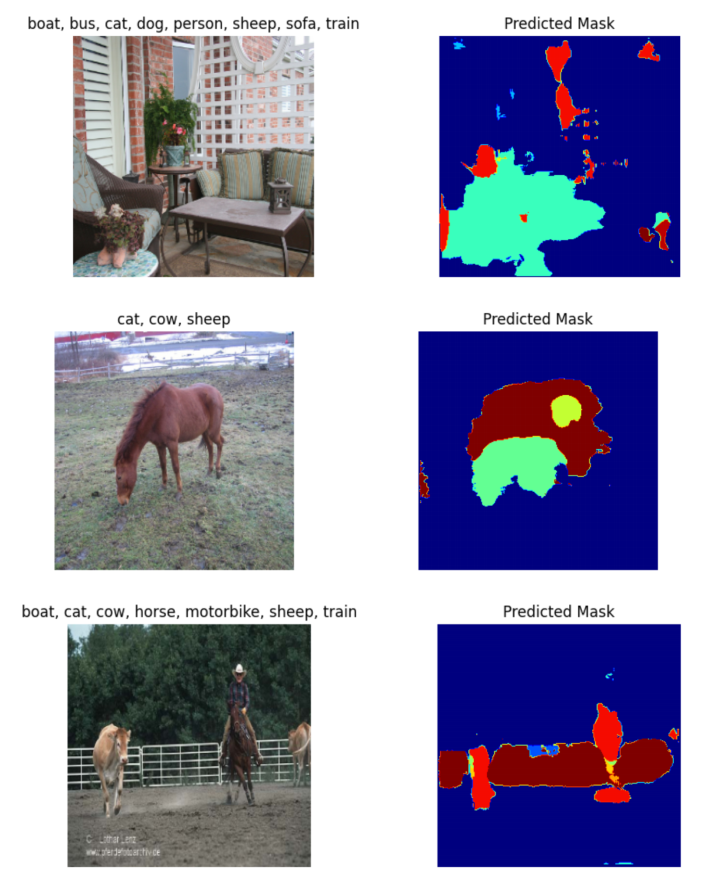

In the corresponding validation loss and IoU curves, we can see a stabilization of the curves while the training curves continue to progress indicating an issue in the generalization of the model.

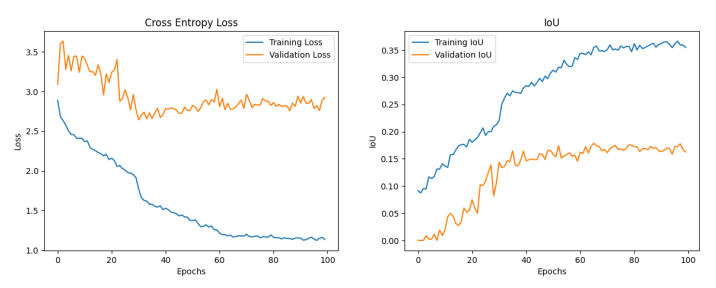 

We then worked more on our customized U-Net model, where we played more with the dropout parameter as well as the weight decay parameter for regularization in order to avoid overfitting, as well as with the learning rate and adaptive learning rate in order to speed up a bit the training. In the below figure, we can see that it looks quite promising as the validation curve followed much more closely our training curves. However, due to limitation of access to GPU it stopped before the end of the training.

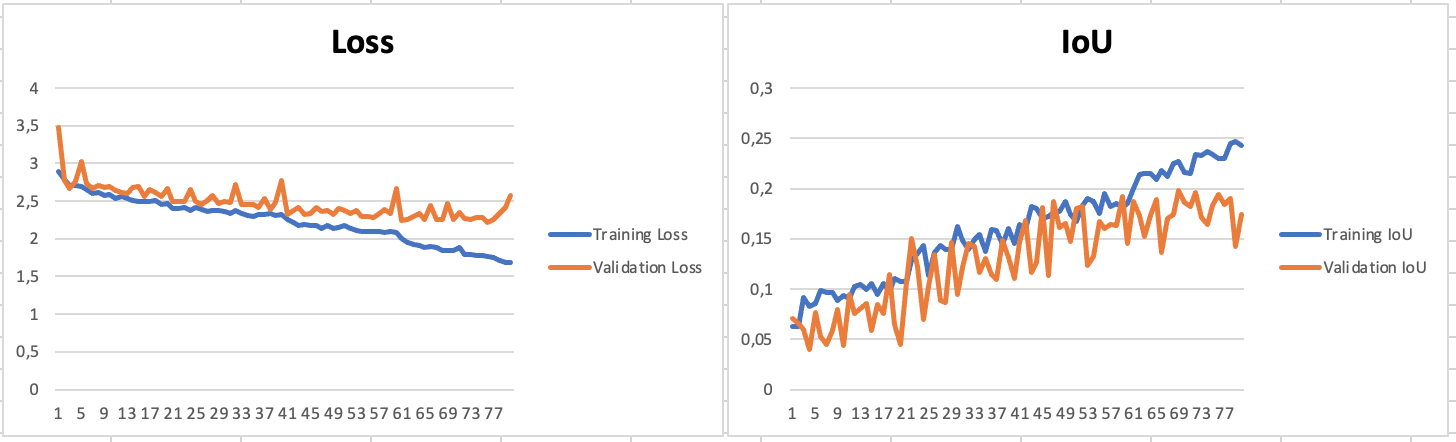

Due to the complexity behind the task of image segmentation, we could notice that the use of pre-trained weights was a huge advantage in term of time and predicted results. Indeed, the models run in parallel to the ones above and that were using a pre-trained model as backbone before fine-tuning on our data were giving better and more promising results. We thus gave up on those scratch models, and finalized our efforts on the pre-trained models which are explained in the next section.

# Our best model is a pretrained model

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [ ]:
generate_submission(test_df)

# 4. Adversarial attack
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.

# 6. Appendices (For documentation purpose only)

# 6.1 Classification Models

#Code to be added by Elias and Jonathan if necessary

# 6.2. Segmentation Models - Code tested in Keras

#Class SegmentationDataset and Creation of training and validation datasets to be used in our models.

    import tensorflow as tf
    import os
    from sklearn.model_selection import train_test_split
    from skimage.transform import resize

    img_files = [f for f in os.listdir("train/img") if not f.startswith(".")]
    n = len(img_files)
    train_files, validation_files = train_test_split(img_files, test_size=0.2, random_state=42)

    class SegmentationDataset(tf.keras.utils.Sequence):
        def __init__(self, img_folder, seg_folder, file_list, batch_size=32, image_size=(256, 256)):
            self.img_folder = img_folder
            self.seg_folder = seg_folder
            self.batch_size = batch_size
            self.image_size = image_size
            self.img_files = file_list
            self.num_samples = len(self.img_files)
            
        def __len__(self):
            return int(np.ceil(self.num_samples / float(self.batch_size)))
        
        def __getitem__(self, idx):
            batch_img_files = self.img_files[idx * self.batch_size: (idx + 1) * self.batch_size]
            batch_imgs = []
            batch_segs = []
            
            for img_file in batch_img_files:
                img_path = os.path.join(self.img_folder, img_file)
                seg_path = os.path.join(self.seg_folder, img_file)
                
                img = np.load(img_path, allow_pickle=True)
                seg = np.load(seg_path, allow_pickle=True)
                seg = tf.expand_dims(seg, axis=-1)
                
                img = resize(img, self.image_size)
                seg = resize(seg, self.image_size, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=False, anti_aliasing_sigma=None)
                
                seg = tf.keras.utils.to_categorical(seg, num_classes=21) if np.max(seg) < 21 else seg
                
                batch_imgs.append(img)
                batch_segs.append(seg)
            
            return np.array(batch_imgs), np.array(batch_segs)
        

    img_folder = "train/img"
    seg_folder = "train/seg"
    batch_size = 32
    image_size = (256, 256)

    train_dataset = SegmentationDataset(img_folder, seg_folder, batch_size=batch_size, image_size=image_size, file_list=train_files)
    val_dataset = SegmentationDataset(img_folder, seg_folder, batch_size=batch_size, image_size=image_size, file_list=validation_files)

#Visualization of one batch of training data (images and segmentation masks)

    import matplotlib.pyplot as plt

    train_images, train_masks = train_dataset[0]    #Get one batch of training data

    for i in range(len(train_images)):  #Loop over the images in this batch
        img = train_images[i]
        mask = train_masks[i]
        
        mask = np.argmax(mask, axis=-1)  #Convert the mask which is a one-hot encoded matrix to a single channel matrix
        
        fig, axes = plt.subplots(1, 2)
        
        #Plot the original image
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        
        #Plot the ground truth segmentation mask
        axes[1].imshow(mask, cmap='jet')
        axes[1].set_title('Ground Truth Segmentation Mask')
        
        plt.show()

#Class weights

    #Count the number of instances for each class
    class_counts = train_df[labels].sum()

    #Calculate class weights
    class_weights = {i: 1.0/count for i, count in enumerate(class_counts)}

    #print("Class weights: ", class_weights)

#Loss Functions:

    

    import tensorflow as tf
    from tensorflow.keras import backend as K
    from keras import metrics

    def dice_loss_ignore_background(y_true, y_pred):
        smooth = 1e-7
        # Exclude background class (class 0) from calculations
        y_true_no_background = y_true[..., 1:]
        y_pred_no_background = y_pred[..., 1:]
        intersection = K.sum(K.abs(y_true_no_background * y_pred_no_background), axis=-1)
        return 1 - (2.0 * intersection + smooth) / (K.sum(K.square(y_true_no_background), -1) + K.sum(K.square(y_pred_no_background), -1) + smooth)


#Class weights

    train_images, train_masks = train_dataset[0]

    class_weights = np.concatenate((np.arange(21), np.zeros(21)),axis=None).reshape((2, 21)).T
    #class_weights = np.concatenate((np.arange(20), np.zeros(20)),axis=None).reshape((2, 20)).T  #for no bg

    n = 0

    #For each image in the batch
    for i in range(len(train_images)):
        mask = train_masks[i]
        mask = np.argmax(mask, axis=-1)

        unique, counts = np.unique(mask, return_counts=True)
        #unique = unique[1:] #for no bg
        #counts = counts[1:] #for no bg
        sum = np.sum(counts)

        weights = np.asarray((unique, counts/sum*100)).T
        
        for weight in weights:
            class_id = int(weight[0])  # Get the class ID
            count_percentage = weight[1]  # Get the count/percentage
            
            # Find the row in `empty_class` with the matching class ID
            row_index = np.where(class_weights[:, 0] == class_id)[0][0]
            #row_index = np.where(class_weights[:, 0] == class_id-1)[0][0]   #for no bg
            
            # Update the second column with the new count/percentage
            class_weights[row_index, 1] += count_percentage

        n +=1

    class_weights[:,1] = class_weights[:,1]/n

    final_weights = class_weights[:,1]/100
    #final_weights_nobg = class_weights[:,1]/100 #for no bg

#Tried Generalized Dice Loss + including a penalty for wrongly classifying foreground classes

#+ tried the possibility to also weight the class in the foreground penalty using final_weights computed above

    import tensorflow as tf
    import keras.backend as K

    def generalized_dice_loss(y_true, y_pred, init_weights=final_weights[1:]):
        #Number of classes
        num_classes = tf.shape(y_pred)[-1]
        
        #Flatten predictions and labels
        y_true_flat = tf.reshape(y_true, (-1, num_classes))
        y_pred_flat = tf.reshape(y_pred, (-1, num_classes))
        
        #Compute class weights based on the frequency of each class
        class_weights = 1.0 / (tf.reduce_sum(y_true_flat, axis=0) ** 2)
        class_weights = tf.where(tf.math.is_finite(class_weights), class_weights, 1e-10)
        print(class_weights)
        
        #Compute Dice score for each class
        numerator = 2.0 * tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        denominator = tf.reduce_sum(y_true_flat + y_pred_flat, axis=0)
        class_dice_scores = (numerator + 1e-10) / (denominator + 1e-10)
        
        #Multiply Dice scores by class weights
        weighted_dice_scores = class_weights * class_dice_scores

        #Compute Generalized Dice Loss
        dice_loss = 1.0 - tf.reduce_sum(weighted_dice_scores) / (tf.reduce_sum(class_weights) + 1e-10)
        
        #Penalize incorrect predictions for foreground classes
        fg_penalty = 1.0 - class_dice_scores[1:]  # Exclude background class
        foreground_loss = tf.reduce_mean(fg_penalty)
        #foreground_loss = tf.reduce_mean(init_weights*fg_penalty)
        
        #Combine Generalized Dice Loss with foreground penalty
        total_loss = dice_loss + 0.5 * foreground_loss
        
        return total_loss

    loss_fn = generalized_dice_loss


#Tried to update the Generalized Dice Loss function as in Reference [3]

#From litterature review, I think Generalized Dice Loss should already compensate for class weights and background...

    def new_generalized_dice_loss(y_true, y_pred):
        # Number of classes
        num_classes = tf.shape(y_pred)[-1]
        
        # Flatten predictions and labels
        y_true_flat = tf.reshape(y_true, (-1, num_classes))
        y_pred_flat = tf.reshape(y_pred, (-1, num_classes))
        
        # Compute class weights based on the frequency of each class
        class_weights = 1.0 / (tf.reduce_sum(y_true_flat, axis=0) ** 2)
        class_weights = tf.where(tf.math.is_finite(class_weights), class_weights, 1e-10)
        
        # Compute Dice score for each class
        numerator = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        denominator = tf.reduce_sum(y_true_flat + y_pred_flat, axis=0)
        
        weighted_num = tf.reduce_sum(class_weights * numerator, axis = -1)
        weighted_den = tf.reduce_sum(class_weights * denominator, axis = -1)
        
        # Compute Generalized Dice Loss
        dice_loss = 1.0 - 2.0 * weighted_num / weighted_den
        #dice_loss = tf.where(tf.math.is_finite(dice_loss), dice_loss, 1e-10)
        
        total_loss = dice_loss

        return total_loss

    #loss_fn = new_generalized_dice_loss

#U-Net model - following the structure from the original paper from Ronneberger et al. (2015)

    from keras.layers import Conv2D, MaxPool2D, Dropout, concatenate, Conv2DTranspose, Input

    def double_conv2D(x, n_filters):   # Two layers of Conv2D with ReLU activation
        x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
        x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

        return x

    def downsample(x, n_filters):
        f = double_conv2D(x, n_filters)
        p = MaxPool2D(2)(f)
        p = Dropout(0.3)(p)

        return f, p

    def upsample(x, conv_features, n_filters):
        x = Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
        x = concatenate([x, conv_features])
        x = Dropout(0.3)(x)
        x = double_conv2D(x, n_filters)

        return x

    def build_unet():
        inputs = Input(shape=(256,256,3))

        #Encoder part: 
        f1, p1 = downsample(inputs, 64)
        f2, p2 = downsample(p1, 128)
        f3, p3 = downsample(p2, 256)
        f4, p4 = downsample(p3, 512)

        #Bottleneck part:
        bottleneck = double_conv2D(p4, 1024)

        #Decoder part
        u6 = upsample(bottleneck, f4, 512)
        u7 = upsample(u6, f3, 256)
        u8 = upsample(u7, f2, 128)
        u9 = upsample(u8, f1, 64)

        outputs = Conv2D(21, 1, padding="same", activation = "softmax")(u9)

        unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

        return unet_model

    unet_model = build_unet()
    
    unet_model.compile(optimizer='adam', loss=loss_fn, metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

    history = unet_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

#SegNet model:

    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
    from tensorflow.keras import regularizers

    def segnet(input_shape, n_classes):
        inputs = Input(input_shape)

        # Encoder
        conv1 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool1)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool2)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        # Decoder
        up4 = UpSampling2D(size=(2, 2))(pool3)
        conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(up4)

        up5 = UpSampling2D(size=(2, 2))(conv4)
        conv5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(up5)

        up6 = UpSampling2D(size=(2, 2))(conv5)
        conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(up6)

        conv7 = Conv2D(n_classes, (1, 1), activation='softmax')(conv6)

        return Model(inputs=[inputs], outputs=[conv7])


    #Instantiate the model
    Segnet = segnet((256, 256, 3), 21)  # Assuming 20 classes and image dimensions are 256x256, in RGB 
    Segnet.compile(optimizer='adam', loss=dice_loss_ignore_background, metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])

    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint

    #Define the early stopping criteria
    early_stop = EarlyStopping(monitor='val_loss', patience=3)  # stop training when 'val_loss' has stopped improving for 3 epochs

    #Define the model checkpoint criteria
    model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # save only the best model to 'best_model.h5'

    #Add the model checkpoint callback to the fit function along with early stopping
    segnet_history = Segnet.fit(train_dataset, epochs=10, callbacks=[early_stop, model_checkpoint])

    import matplotlib.pyplot as plt

    #Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(segnet_history.history['auc'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    #Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(segnet_history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    plt.show()

#Create TestDataset class:

    class TestDataset(tf.keras.utils.Sequence):
        def __init__(self, img_folder, file_list, batch_size=32, image_size=(256, 256)):
            self.img_folder = img_folder
            self.batch_size = batch_size
            self.image_size = image_size
            self.img_files = file_list
            self.num_samples = len(self.img_files)
            
        def __len__(self):
            return int(np.ceil(self.num_samples / float(self.batch_size)))
        
        def __getitem__(self, idx):
            batch_img_files = self.img_files[idx * self.batch_size: (idx + 1) * self.batch_size]
            batch_imgs = []
            
            for img_file in batch_img_files:
                img_path = os.path.join(self.img_folder, img_file)
                
                img = np.load(img_path, allow_pickle=True)
                img = resize(img, self.image_size)
                
                batch_imgs.append(img)
            
            return np.array(batch_imgs)

    #Assuming you have a list of test files and the test images are in the 'test/img' folder
    test_img_folder = "test/img"
    test_files = [f for f in os.listdir(test_img_folder) if not f.startswith(".")]

#Predict on test with unet or segnet:

    test_dataset = TestDataset(test_img_folder, batch_size=batch_size, image_size=image_size, file_list=test_files)
    predictions = unet_model.predict(test_dataset)
    
    test_dataset = TestDataset(test_img_folder, batch_size=batch_size, image_size=image_size, file_list=test_files)
    predictions = Segnet.predict(test_dataset)

#Plot predicted masks on test data:

    import matplotlib.pyplot as plt

    #Get a batch of data from the test dataset
    test_images = test_dataset[0]

    #Get the corresponding predictions
    test_predictions = predictions[:len(test_images)]

    #For each image in the batch
    for i in range(len(test_images)):
        # Get the image and its corresponding prediction
        img = test_images[i]
        pred = test_predictions[i]
        
        # The prediction is a one-hot encoded matrix, we need to convert it to a single channel matrix
        pred = np.argmax(pred, axis=-1)
        
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2)
        
        # Plot the original image in the first subplot
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        
        # Plot the predicted segmentation mask in the second subplot
        axes[1].imshow(pred, cmap='jet')
        axes[1].set_title('Predicted Segmentation Mask')
        
        # Show the figure
        plt.show()